# Modeling the displacements of the longitudinal mode

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from flaml import AutoML
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import NuSVR

In [3]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [4]:
df_params.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.99,43.23,2,78.22,59.51,...,0.17,0.14,0.14,0.15,0.00,0.96,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.17,45.86,2,78.92,57.21,...,0.17,0.15,0.14,0.14,0.00,0.96,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.53,45.26,2,80.10,49.22,...,0.29,0.27,0.28,0.28,0.00,0.99,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.43,51.01,2,74.76,50.84,...,0.24,0.18,0.18,0.19,0.00,0.97,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.58,45.98,2,78.77,64.70,...,0.26,0.26,0.28,0.29,0.00,0.99,0,0,0,1


The columns of the DataFrame df_params are listed in the text file df_params_cols.txt

In [5]:
lst_param = df_params.columns.to_list()

# Preparation of the variables

Definition of the explanatory variables (geometrical parameters)

In [6]:
# Explanatory variables
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

Visualization of the displacements?

In [7]:
# Import of the 400 displacement values of the longitudinal modes
lst_disp_long = lst_param[139:539]
df_disp = df_params[lst_disp_long]

In [8]:
# Scale all explanatory variables, except the slot class encoded columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[lst_expl])
X = pd.concat([pd.DataFrame(X_scaled, columns=lst_expl, index=X.index), X[lst_slot_class]], axis=1)
X

,dim_x,dim_y,dim_z,slot_x_length,slot_x_distance,slot_z_length,slot_z_distance,chamfer_x_dim_y,chamfer_x_dim_z,chamfer_y_dim_x,...,cut_x_depth,cut_z_start,cut_z_end,cut_z_depth,seg_x_out,seg_z_out,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,0.05,0.68,0.27,-0.96,-1.22,-0.11,-0.43,0.97,0.35,-1.23,...,-1.18,-1.00,1.19,-0.39,-0.29,-0.62,0,0,0,1
1,-1.34,0.96,-1.62,1.03,-1.00,0.16,-0.59,0.29,-0.02,1.04,...,1.63,-0.76,-0.14,1.59,-0.62,-0.59,0,0,0,1
2,0.74,-1.14,-1.65,-0.37,-1.05,0.62,-1.16,-1.32,-0.01,-0.65,...,-0.94,-1.42,-0.87,-1.22,-0.56,-0.18,0,0,0,1
3,-1.29,-1.26,-1.47,1.51,-0.56,-1.44,-1.05,0.36,0.48,-1.22,...,1.14,0.68,0.11,-1.08,-1.13,-0.34,0,0,0,1
4,0.52,-0.44,0.90,-0.74,-0.99,0.10,-0.06,1.01,0.17,1.11,...,-1.35,-0.71,-0.83,-1.28,-0.54,-0.80,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,0.16,-0.17,-0.41,-0.07,1.94,-0.56,-0.78,0.49,-1.64,0.34,...,-1.16,-0.31,1.31,1.50,1.31,-0.42,1,0,0,0
7986,1.10,-0.94,0.51,-0.22,1.18,0.50,-0.16,-0.12,-0.52,-1.67,...,-0.73,0.21,1.00,1.62,1.65,-0.72,1,0,0,0
7987,-0.86,-0.76,-0.64,0.73,2.03,0.35,-0.38,-0.53,-1.66,0.38,...,1.27,0.91,0.44,-1.07,1.27,-0.68,1,0,0,0
7988,-0.34,-0.17,-0.51,-1.41,1.37,-1.40,-0.58,-0.79,0.29,-1.67,...,0.50,0.46,-0.13,1.73,1.53,-0.55,1,0,0,0


# Prediction of the Norm of the Relative Displacement Deviation (NRDD) of the output displacement

The goal is to predict the displacement uniformity of the output surface. The values of the displacement at each node are not required, only the uniformity matters to evaluate the displacement (like a score). During the feature preprocessing we defined two uniformity criterions: NRDD and MAC values 

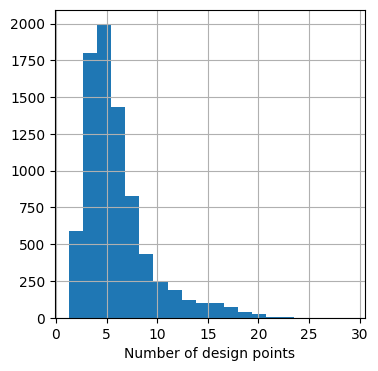

In [ ]:
# Target variable: relative mean squared deviation
target = 'long_disp_rmsd'
y = df_params[target]

fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(y, bins=20)
plt.xlabel('NRDD')
plt.ylabel('Number of design points')
plt.grid(True)
plt.show()

# Perform a new split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

Most of the design points lead to a uniformity around 5. The chosen metric to evaluate the predictions will be the Coefficient of Determination R², very common for regression problems.

### LazyPredict

In [ ]:
reg = LazyRegressor(verbose=1, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.49276387307121783, 'Adjusted R-Squared': -0.5184356084679842, 'RMSE': 3.986483693631054, 'Time taken': 2.6685519218444824}
{'Model': 'BaggingRegressor', 'R-Squared': 0.571546487770528, 'Adjusted R-Squared': 0.564178178961486, 'RMSE': 2.1357297025683533, 'Time taken': 4.931817531585693}
{'Model': 'BayesianRidge', 'R-Squared': 0.5031744982657762, 'Adjusted R-Squared': 0.4946303654334041, 'RMSE': 2.2998333842797676, 'Time taken': 0.031432151794433594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.22639436703830218, 'Adjusted R-Squared': 0.21309032112112636, 'RMSE': 2.8698172760065397, 'Time taken': 0.6741821765899658}
{'Model': 'DummyRegressor', 'R-Squared': -8.23168199182156e-05, 'Adjusted R-Squared': -0.017281184688795914, 'RMSE': 3.2629641941292937, 'Time taken': 0.028450489044189453}
{'Model': 'ElasticNet', 'R-Squared': 0.21465931210532863, 'Adjusted R-Squared': 0.20115345314153488, 'RMSE': 2.8915019081170117, 'Time taken': 0.02914381

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
MLPRegressor,0.72,0.72,1.71,5.87
LGBMRegressor,0.67,0.67,1.87,0.13
HistGradientBoostingRegressor,0.66,0.66,1.90,29.71
ExtraTreesRegressor,0.64,0.65,1.94,11.73
XGBRegressor,0.62,0.63,1.99,0.21


### FLAML

In [ ]:
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'time_budget': 300,
     'metric': 'r2',
     'n_splits': 5,
     'log_file_name': 'automl-nrdd.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))

[flaml.automl.logger: 05-17 17:56:33] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 17:56:33] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 17:56:33] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-17 17:56:33] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 17:56:33] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 17:56:33] {2393} INFO - Estimated sufficient time budget=1646s. Estimated necessary time budget=12s.
[flaml.automl.logger: 05-17 17:56:33] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.8410,	best estimator lgbm's best error=0.8410
[flaml.automl.logger: 05-17 17:56:33] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 17:56:33] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.8410,	best estimator lgbm's best error=0.8410
[flaml.automl.logger: 05-17 17:56:33] {2258} 

### Cross validation

In [46]:
dict_models = {
            'LGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True),
            'XGB': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1),
            'MLP': MLPRegressor()
        }

In [47]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    print ('Scores R² of the 5 splits:', scores)
    print ('Score mean R²:', scores.mean())
    print ('Score standard deviation R²:', scores.std())

-----------------------
** Model: LGBM
Scores R² of the 5 splits: [0.61635139 0.58102917 0.62203401 0.58057908 0.65262494]
Score mean R²: 0.6105237179690765
Score standard deviation R²: 0.02722341440858688
-----------------------
** Model: XGB
Scores R² of the 5 splits: [0.61089722 0.5737779  0.61464133 0.57378783 0.64621243]
Score mean R²: 0.6038633399572395
Score standard deviation R²: 0.02745452974606184
-----------------------
** Model: MLP
Scores R² of the 5 splits: [0.66741044 0.65618611 0.68549858 0.67028347 0.71022476]
Score mean R²: 0.6779206738107784
Score standard deviation R²: 0.018666343337862906


# Prediction of the inverse of the NRDD

As previously mentioned the NRDD tends zo zero for uniform displacements (low deviation) and to high values for poor uniformity. If we take a look at the distribution of the inverse, it is thinkable that the prediction would be more accurable since the histogramm is less skewed. The design points with high values of 1/NRDD show a uniform displacement, which is a more intuitive metric.

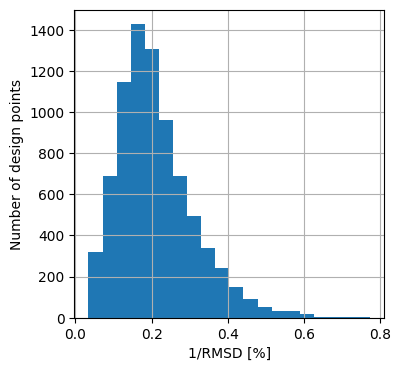

In [ ]:
# Target variable: relative mean squared deviation
target = 'long_disp_rmsd'
y = 1/df_params[target]

fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(y, bins=20)
plt.xlabel('1/NRDD')
plt.ylabel('Number of design points')
plt.grid(True)
plt.show()

# Perform a new split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

### LazyPredict

In [58]:
reg = LazyRegressor(verbose=1, ignore_warnings=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4298639137149579, 'Adjusted R-Squared': 0.42005902560687114, 'RMSE': 0.07389117309271716, 'Time taken': 2.186950445175171}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6531831444910854, 'Adjusted R-Squared': 0.6472187781861549, 'RMSE': 0.05763063362662763, 'Time taken': 4.363788366317749}
{'Model': 'BayesianRidge', 'R-Squared': 0.6078041542975483, 'Adjusted R-Squared': 0.6010593849765506, 'RMSE': 0.06128508473827955, 'Time taken': 0.038897037506103516}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.2576361721392363, 'Adjusted R-Squared': 0.24486940567284088, 'RMSE': 0.08431633051589354, 'Time taken': 0.6508893966674805}
{'Model': 'DummyRegressor', 'R-Squared': -3.4162702933215883e-07, 'Adjusted R-Squared': -0.01719779973144342, 'RMSE': 0.09785958519401307, 'Time taken': 0.025931358337402344}
{'Model': 'ElasticNet', 'R-Squared': -3.4162702933215883e-07, 'Adjusted R-Squared': -0.01719779973144342, 'RMSE': 0.09785958519401307, 'Time taken':

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
NuSVR,0.76,0.76,0.05,24.83
LGBMRegressor,0.73,0.74,0.05,0.22
HistGradientBoostingRegressor,0.73,0.73,0.05,0.90
XGBRegressor,0.70,0.71,0.05,0.26
ExtraTreesRegressor,0.69,0.70,0.05,13.18


### FLAML

In [ ]:
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'time_budget': 300,
     'metric': 'r2',
     'n_splits': 5,
     'log_file_name': 'automl-nrdd-inverse.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))

[flaml.automl.logger: 05-17 19:08:14] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 19:08:14] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 19:08:14] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-17 19:08:14] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 19:08:14] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 19:08:14] {2393} INFO - Estimated sufficient time budget=957s. Estimated necessary time budget=7s.
[flaml.automl.logger: 05-17 19:08:14] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.8197,	best estimator lgbm's best error=0.8197
[flaml.automl.logger: 05-17 19:08:14] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 19:08:14] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.8197,	best estimator lgbm's best error=0.8197
[flaml.automl.logger: 05-17 19:08:14] {2258} IN

### Cross validation

In [63]:
dict_models = {
            'LGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True),
            'XGB': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1),
            'MLP': MLPRegressor(),
            'NuSVR': NuSVR()
        }

In [64]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    print ('Scores R² of the 5 splits:', scores)
    print ('Score mean R²:', scores.mean())
    print ('Score standard deviation R²:', scores.std())

-----------------------
** Model: LGBM
Scores R² of the 5 splits: [0.72105735 0.71013944 0.73392474 0.72291252 0.75424745]
Score mean R²: 0.7284562997453508
Score standard deviation R²: 0.014940366568728452
-----------------------
** Model: XGB
Scores R² of the 5 splits: [0.7198563  0.70732627 0.71594767 0.71695321 0.75252445]
Score mean R²: 0.722521578582854
Score standard deviation R²: 0.015571746027759978
-----------------------
** Model: MLP
Scores R² of the 5 splits: [0.32913787 0.41464727 0.31857347 0.31677842 0.46727194]
Score mean R²: 0.36928179349362383
Score standard deviation R²: 0.06099109621543939
-----------------------
** Model: NuSVR
Scores R² of the 5 splits: [0.71916232 0.72326274 0.73048517 0.7346406  0.75389189]
Score mean R²: 0.7322885421050668
Score standard deviation R²: 0.012076852741588468


### Conclusion

The benchmark with LazyPredict gives the best score means and deviations for:
* 1. NuSVR estimator
* 2. LightGBM
* 3. XGBoost
which are confirmed by the cross-validation. FLAML sees XGBoost as the best estimator with other hyperparameters.

# Transformation of the NRDD

We saw that inverse of the NRDD could be better predicted, one can try other transformations for the target variable and compare the scores of predictions.

In [ ]:
# Target variable: relative mean squared deviation
target = 'long_disp_nrdd'
y = df_params[[target]]

In [ ]:
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, RobustScaler, QuantileTransformer, PolynomialFeatures

dict_transfs = {
                'Inverse': FunctionTransformer(lambda y: 1/y),
                'InverseSquare': FunctionTransformer(lambda y: 1/y**2),
                'Logarithm': FunctionTransformer(np.log10),
                'InverseLogarithm': FunctionTransformer(lambda y: 1/np.log10(y)),
                'LogarithmInverse': FunctionTransformer(lambda y: np.log10(1/y)),
                'StandardScaler': StandardScaler(),
                'PowerTransformer': PowerTransformer(),
                'QuantileTransformer': QuantileTransformer(),
                'RobustScaler': RobustScaler(),
                'RootSquare': FunctionTransformer(lambda y: np.sqrt(y)),
                'InverseRootSquare': FunctionTransformer(lambda y: 1/np.sqrt(y)),
            }

model = LGBMRegressor(n_estimators=100, learning_rate=0.1, force_col_wise=True)

In [83]:
results = pd.DataFrame()

for name, transf in dict_transfs.items():

    print ('---------------')
    print ('** Transformation:', name)

    y_transf = transf.fit_transform(y)    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transf, test_size = 0.2, random_state=55)
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    results[name] = pd.DataFrame([scores.mean(), scores.std()], index=['Score Mean', 'Standard Deviation'])

results

---------------
** Transformation: Inverse
[LightGBM] [Info] Total Bins 5854
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 0.211076
[LightGBM] [Info] Total Bins 5857
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 0.212197
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 0.211123
[LightGBM] [Info] Total Bins 5860
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 0.210799
[LightGBM] [Info] Total Bins 5861
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 0.211285
---------------
** Transformation: InverseSquare
[LightGBM] [I

,Inverse,InverseSquare,Logarithm,InverseLogarithm,LogarithmInverse,StandardScaler,PowerTransformer,QuantileTransformer,RobustScaler
Score Mean,0.73,0.64,0.73,0.64,0.73,0.61,0.74,0.76,0.61
Standard Deviation,0.01,0.02,0.02,0.04,0.02,0.03,0.02,0.02,0.03


The QuantileTransformer transforms the target variable NRDD to follow a normal distribution and reduce the impact of outliers.

# Prediction of the MAC value (correlation criterion)

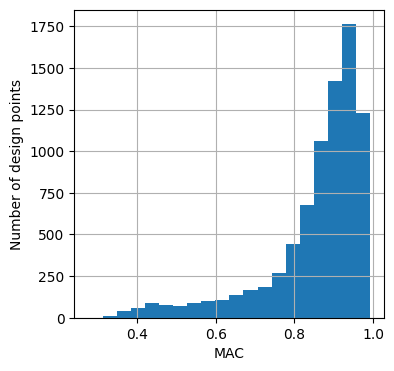

In [50]:
# Target variable: calculated MAC value in the FEM (value between 0 and 1)
target = 'mode_mac_long'
y = df_params[target]

fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(y, bins=20)
plt.xlabel('MAC')
plt.ylabel('Number of design points')
plt.grid(True)
plt.show()

# Perform a new split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=55)

Chosen metric: Mean squared error computes the average squared error between the true values and the predictions

### LazyPredict

In [ ]:
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric='mse')
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

### FLAML

In [ ]:
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'time_budget': 300,
     'metric': 'mse',
     'n_splits': 5,
     'log_file_name': 'automl-mac.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('MSE score:', mean_squared_error(y_test, y_pred))

[flaml.automl.logger: 05-17 12:09:34] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 12:09:34] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 12:09:34] {1838} INFO - Minimizing error metric: mse
[flaml.automl.logger: 05-17 12:09:34] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 12:09:34] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 12:09:34] {2393} INFO - Estimated sufficient time budget=988s. Estimated necessary time budget=7s.
[flaml.automl.logger: 05-17 12:09:34] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.7410,	best estimator lgbm's best error=0.7410
[flaml.automl.logger: 05-17 12:09:34] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 12:09:34] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.7410,	best estimator lgbm's best error=0.7410
[flaml.automl.logger: 05-17 12:09:34] {2258} INF

### Cross validation

In [ ]:
dict_models = {
            'ExtraTrees': ExtraTreesRegressor(n_estimators=175),
            'LGBMRegressor': LGBMRegressor(force_col_wise=True),
            'XGB': xgb.XGBRegressor(),
            'MLP': MLPRegressor(max_iter=2000)
        }

In [ ]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    print ('Scores MSE of the 5 splits:', scores)
    print ('Score mean MSE:', scores.mean())
    print ('Score standard deviation MSE:', scores.std())

-----------------------
** Model: ExtraTrees
Scores MSE of the 5 splits: [-0.36460973 -0.3898607  -0.36915899 -0.34486517 -0.37907414]
Score mean MSE: -0.36951374675829307
Score standard deviation MSE: 0.01508063327330302
-----------------------
** Model: LGBMRegressor
Scores MSE of the 5 splits: [-0.37883754 -0.40109415 -0.37784067 -0.36016109 -0.38452249]
Score mean MSE: -0.3804911884470416
Score standard deviation MSE: 0.013143867230418717
-----------------------
** Model: XGB
Scores MSE of the 5 splits: [-0.41295452 -0.40659287 -0.40676831 -0.38718149 -0.410607  ]
Score mean MSE: -0.4048208363104216
Score standard deviation MSE: 0.009140193164142522
-----------------------
** Model: MLP
Scores MSE of the 5 splits: [-0.52850374 -0.51519911 -0.54191222 -0.50671141 -0.53433103]
Score mean MSE: -0.5253315005348691
Score standard deviation MSE: 0.012769871839581688


# Dimension reduction and predictions of the first PCA components

In this section we will reduce the set of 400 columns to a lower number with the help of a Principal Component Analysis

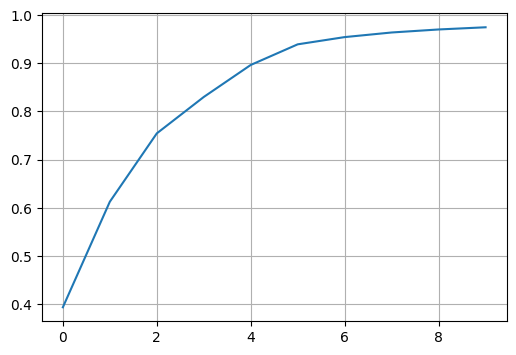

Explained sum of variance with 10 components: 0.9749089406825361


In [8]:
df_disp = df_params[lst_disp_long]

nb_pca_comp = 10
pca = PCA(n_components=nb_pca_comp)
col_disp_pca = ['disp_long_pca_' + str(x) for x in range(nb_pca_comp)]
df_disp_pca = pd.DataFrame(pca.fit_transform(df_disp), columns=col_disp_pca)

plt.figure(figsize=[6, 4])
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.grid(True)
plt.show()
print ('Explained sum of variance with 10 components:', pca.explained_variance_ratio_.cumsum()[-1])

With 10 components the cumulative sum of the variance is above 95%

In [ ]:
df_disp_pca

,disp_long_pca_0,disp_long_pca_1,disp_long_pca_2,disp_long_pca_3,disp_long_pca_4,disp_long_pca_5,disp_long_pca_6,disp_long_pca_7,disp_long_pca_8,disp_long_pca_9
0,0.18,-0.53,-0.06,-0.14,-0.13,-0.18,-0.01,0.14,0.06,0.00
1,-0.05,-0.53,-0.22,-0.16,0.13,-0.14,0.02,-0.06,-0.02,0.00
2,0.09,0.16,-0.93,-0.01,0.05,0.13,0.03,0.02,-0.01,0.00
3,-0.16,-0.35,-0.75,-0.21,0.17,0.21,0.00,-0.03,0.00,0.01
4,0.26,0.08,-0.68,0.06,0.09,0.02,-0.05,0.15,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...
7985,-0.28,0.06,-0.32,0.41,-0.21,0.29,0.17,-0.19,-0.02,0.00
7986,2.30,-0.47,0.31,0.47,-0.28,0.17,-0.32,-0.03,0.00,0.07
7987,0.03,0.47,-0.51,0.28,0.04,0.27,0.38,-0.44,-0.02,0.09
7988,-2.45,0.03,1.29,0.44,-0.46,-0.28,0.40,0.16,-0.01,0.01


When we visualize the 2D-distribution of the first components, two clusters are clearly visible in the first component:

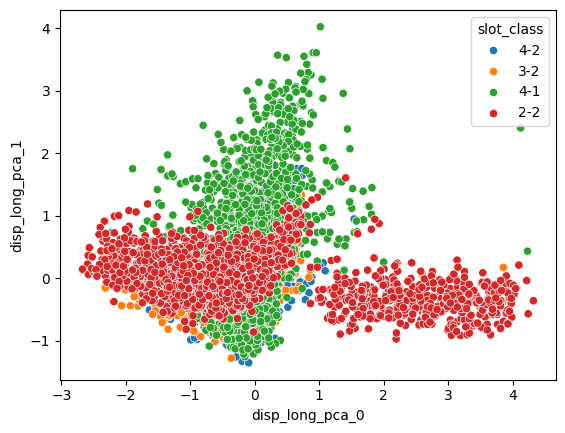

In [ ]:
df = pd.concat([df_params, df_disp_pca], axis=1)
sns.scatterplot(data=df, x='disp_long_pca_0', y='disp_long_pca_1', hue='slot_class')
plt.show()

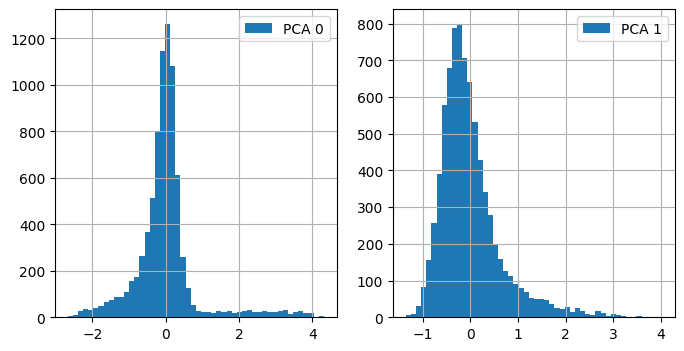

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax0 = fig.add_subplot(121)
plt.grid(True)
ax0.hist(df_disp_pca['disp_long_pca_0'], bins=50, label='PCA 0')
plt.legend()

ax1 = fig.add_subplot(122)
plt.grid(True)
ax1.hist(df_disp_pca['disp_long_pca_1'], bins=50, label='PCA 1')
plt.legend()
plt.show()

## First component PCA 0

In [ ]:
target = 'disp_long_pca_0'
y = df_disp_pca[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

### LazyPredict

In [ ]:
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric='r2')
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

### FLAML

In [ ]:
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'metric': 'r2',
     'time_budget': 300,
     'n_splits': 5,
     'log_file_name': 'automl-pca0.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))

[flaml.automl.logger: 05-17 11:57:32] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 11:57:32] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 11:57:32] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-17 11:57:32] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 11:57:32] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 11:57:33] {2393} INFO - Estimated sufficient time budget=1167s. Estimated necessary time budget=8s.
[flaml.automl.logger: 05-17 11:57:33] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.9651,	best estimator lgbm's best error=0.9651
[flaml.automl.logger: 05-17 11:57:33] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 11:57:33] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.9651,	best estimator lgbm's best error=0.9651
[flaml.automl.logger: 05-17 11:57:33] {2258} I

### Cross validation

In [ ]:
dict_models = {
            'ExtraTrees': ExtraTreesRegressor(n_estimators=270),
            'LGBMRegressor': LGBMRegressor(force_col_wise=True),
            'XGB': xgb.XGBRegressor(),
            'MLP': MLPRegressor(max_iter=2000)
        }

In [ ]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    print ('Scores R² of the 5 splits:', scores)
    print ('Score mean R²:', scores.mean())
    print ('Score standard deviation R²:', scores.std())

-----------------------
** Model: ExtraTrees
Scores R² of the 5 splits: [0.26001464 0.2721447  0.30706494 0.25450522 0.26943746]
Score mean R²: 0.2726333908691964
Score standard deviation R²: 0.018351283238988676
-----------------------
** Model: LGBMRegressor
[LightGBM] [Info] Total Bins 5854
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 0.005570
[LightGBM] [Info] Total Bins 5857
[LightGBM] [Info] Number of data points in the train set: 5113, number of used features: 27
[LightGBM] [Info] Start training from score 0.004442
[LightGBM] [Info] Total Bins 5859
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 0.003724
[LightGBM] [Info] Total Bins 5860
[LightGBM] [Info] Number of data points in the train set: 5114, number of used features: 27
[LightGBM] [Info] Start training from score 0.009100
[LightGBM] [Info] Total

## Second component PCA 1

The second component is not so clustered as the first component. However a gap seems to be present around the value -1

In [ ]:
target = 'disp_long_pca_1'
y = df_disp_pca[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

### LazyPredict

[flaml.automl.logger: 04-26 11:46:22] {1728} INFO - task = regression
[flaml.automl.logger: 04-26 11:46:22] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-26 11:46:22] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-26 11:46:22] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 04-26 11:46:22] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-26 11:46:22] {2393} INFO - Estimated sufficient time budget=793s. Estimated necessary time budget=6s.
[flaml.automl.logger: 04-26 11:46:22] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.8729,	best estimator lgbm's best error=0.8729
[flaml.automl.logger: 04-26 11:46:22] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-26 11:46:22] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.8729,	best estimator lgbm's best error=0.8729
[flaml.automl.logger: 04-26 11:46:22] {2258} IN

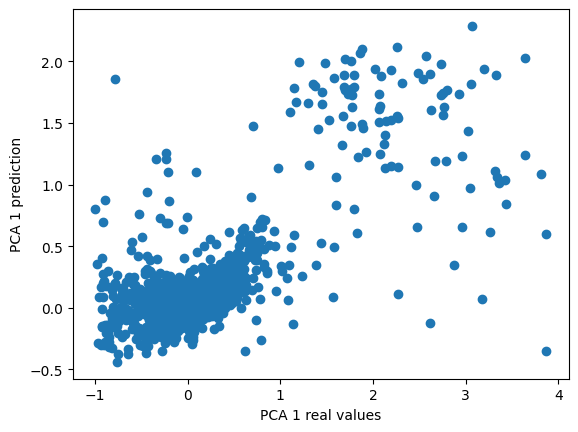

In [ ]:
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric='r2')
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

### FLAML

In [ ]:
automl = AutoML()
automl_settings = {
    'task': 'regression',
     'metric': 'r2',
     'time_budget': 300,
     'n_splits': 5,
     'log_file_name': 'automl-pca1.log'
     }
automl.fit(X_train, y_train, **automl_settings)

print ('The best estimator found my FLAML:', automl.best_estimator)
print('Best config:', automl.best_config_per_estimator[automl.best_estimator])

y_pred = automl.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))

[flaml.automl.logger: 05-17 13:04:39] {1728} INFO - task = regression
[flaml.automl.logger: 05-17 13:04:39] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-17 13:04:39] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 05-17 13:04:39] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 05-17 13:04:39] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-17 13:04:39] {2393} INFO - Estimated sufficient time budget=1008s. Estimated necessary time budget=7s.
[flaml.automl.logger: 05-17 13:04:39] {2442} INFO -  at 0.2s,	estimator lgbm's best error=0.7360,	best estimator lgbm's best error=0.7360
[flaml.automl.logger: 05-17 13:04:39] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-17 13:04:40] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.7360,	best estimator lgbm's best error=0.7360
[flaml.automl.logger: 05-17 13:04:40] {2258} I

### Cross validation

In [ ]:
dict_models = {
            'ExtraTrees': ExtraTreesRegressor(n_estimators=270),
            'LGBMRegressor': LGBMRegressor(n_estimators=5400, max_leaves=60, learning_rate=4.5e-2, force_col_wise=True),
            'XGB': xgb.XGBRegressor(),
            'MLP': MLPRegressor(max_iter=2000)
        }

In [ ]:
for name, model in dict_models.items():

    print ('-----------------------')
    print ('** Model: ' + name)

    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    print ('Scores R² of the 5 splits:', scores)
    print ('Score mean R²:', scores.mean())
    print ('Score standard deviation R²:', scores.std())

-----------------------
** Model: ExtraTrees
Scores R² of the 5 splits: [0.87332619 0.85655524 0.87274123 0.87611504 0.87005047]
Score mean R²: 0.8697576353077776
Score standard deviation R²: 0.006876656115624462
-----------------------
** Model: LGBMRegressor
Scores R² of the 5 splits: [0.91573547 0.90866366 0.92277107 0.92319553 0.92087967]
Score mean R²: 0.918249077590842
Score standard deviation R²: 0.0054778498338639015
-----------------------
** Model: XGB
Scores R² of the 5 splits: [0.89113902 0.88524847 0.89171543 0.89700888 0.89555413]
Score mean R²: 0.8921331871836244
Score standard deviation R²: 0.00409969298208501
-----------------------
** Model: MLP
Scores R² of the 5 splits: [0.92114107 0.91418088 0.9186253  0.92746733 0.92258424]
Score mean R²: 0.9207997637805286
Score standard deviation R²: 0.004388510755575013


Save the PCA for the hyperparameters tuning in the other notebooks

In [ ]:
ft_pca_path = os.path.join(base_dir, 'Scripts', str(fam) + '-pca-long-displacements.ft')

# Reset index for feather exports
df_disp_pca.reset_index(drop=True, inplace=True)

# Export DataFrames as binary file
df_disp_pca.to_feather(ft_pca_path)